In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics_R
from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data_nD
from project_utils.surroagte_gp     import Surrogate_GP



In [2]:
Num_Points    = 5
Title         = 'Synthetic Regression'
FUR_Weight    = 0.5
N_consistancy = 25
consist_bound = 0.3

In [3]:
if isinstance(FUR_Weight, float):
    FUR_Weight = [FUR_Weight, 1.0 - FUR_Weight]
    
print(FUR_Weight)

[0.5, 0.5]


In [4]:
Title = Title + ' W:'+ str(FUR_Weight)

In [5]:
# Load Forrester model

Reg_Data = BB_Model(dataset = 'Synthetic_Reg', Feature_Counts=[16,12])

#Reg_Data.df().head()

In [6]:
Reg_Data.MPL()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.4971582087655845


MLPRegressor(random_state=RandomState(MT19937) at 0x2C0FF9B9840)

In [7]:
Reg_Data.Random_Forest()

0.41765456647097976


RandomForestRegressor(random_state=RandomState(MT19937) at 0x2C0FF9B9840)

In [8]:
Reg_Data.GP()

-0.013848459603677865


GaussianProcessRegressor()

In [9]:
Reg_Data.L_Regression()

0.4848460441433098


LinearRegression()

In [10]:
print(Reg_Data.get_features())

['Passive_0', 'Passive_1', 'Active_2', 'Active_3', 'Active_4', 'Active_5', 'Active_6', 'Active_7']


In [11]:
#Default settings
from unravel_2.ur_model import UR_Model

X_train, X_test, y_train, y_test = Reg_Data.get_TT_data()

#Initializing the explainer object
URM_Exp = UR_Model(bbox_model           = Reg_Data.get_Random_Forest(),
                   train_data           = X_train,
                   feature_names        = Reg_Data.get_features(),
                   categorical_features = Reg_Data.get_catagorical(),
                   mode                 = Reg_Data.get_mode(),
                   sampling_optimize    = "opt")

#sur_GP = Surrogate_GP()


In [12]:
#I2nd explainer object
URM_Exp_2 = UR_Model(bbox_model           = Reg_Data.get_L_Regression(),
                     train_data           = X_train,
                     feature_names        = Reg_Data.get_features(),
                     categorical_features = Reg_Data.get_catagorical(),
                     mode                 = Reg_Data.get_mode(),
                     sampling_optimize    = "opt")



In [13]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [16.05097732  5.71644846 15.53121452 12.21273216  8.96727666 13.91710247
 -5.72707063 16.30306602]
Std 0:  [2.39479904 5.75752024 4.58702215 5.30758541 4.95485397 1.86888975
 2.34673674 3.10454533]


In [14]:
# Generate explantion data for Random Forest

Reg_Stats   = Feature_Statistics_R(feature_names = Reg_Data.get_features(),
                                   mode          = Reg_Data.get_mode(),
                                   X_train_std   = Reg_Data.get_X_train_std(),
                                   N_consistancy = N_consistancy)

Reg_Stats_2 = Feature_Statistics_R(feature_names = Reg_Data.get_features(),
                                   mode          = Reg_Data.get_mode(),
                                   X_train_std   = Reg_Data.get_X_train_std())


if Num_Points > X_test.shape[0]: Num_Points = X_test.shape[0]

elif Num_Points == 0:            Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
    data_row  = np.array([X_test[test_instance]])
    
#    data_row  = np.array([0.4])

#    print('data row ',data_row)
    
    URM_Exp.explain(X_init      = data_row.reshape(1, -1),
                    Dimension   = 'Multi D',
                    kernel_type = "Matern",
                    max_iter    = 20,
                    alpha       = "FUR_W",
                    #jitter=5,
                    interval    = 1,
                    weight      = FUR_Weight)
       
    f_predict = Reg_Data.get_Random_Forest().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    acq_data = URM_Exp.get_acq_data()
    
#    X, y = URM_Exp.get_surrogate_data()

#    e_predict = sur_GP.predict(X, y)
#    e_predict = sur_GP.predict(URM_Exp.get_surrogate_data())

    print(f_predict, e_predict, acq_data.get_fe_x0())
    
    scores = URM_Exp.permutation_importance()
    
    consistancy = URM_Exp.Y_Consistancy(N_points = N_consistancy, std_bound = consist_bound)
    
    URM_Exp.del_1_rel()
    
    del_1_var = URM_Exp.get_del_1_variance()
    
    Reg_Stats.Add_Sample(sample_scores = scores,
                         outcome       = y_test[test_instance],
                         X_row         = data_row.reshape(1, -1),
                         f_prediction  = f_predict,
                         e_prediction  = e_predict.ravel(),
                         feopt         = acq_data.get_fe_x0(),
                         consistancy   = consistancy,
                         del_1_var     = del_1_var)
    
    
    ############################################################################################
    
    URM_Exp_2.explain(X_init      = data_row.reshape(1, -1),
                      Dimension   = 'Multi D',
                      kernel_type = "Matern",
                      max_iter    = 20,
                      alpha       = "FUR_W",
                      #jitter=5,
                      interval    = 1,
                      weight      = FUR_Weight)
       
    f_predict = Reg_Data.get_L_Regression().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp_2.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    scores = URM_Exp_2.permutation_importance()
    
    Reg_Stats_2.Add_Sample(sample_scores = scores,
                           outcome       = y_test[test_instance],
                           X_row         = data_row.reshape(1, -1),
                           f_prediction  = f_predict,
                           e_prediction  = e_predict.ravel(),
                           feopt         = None)
    


INSTANCE:  0
Acq_Data_nD
[104.64808954] [1.04648090e+02 1.00000004e-05] [104.64808957]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

INSTANCE:  1
Acq_Data_nD
[89.07249046] [8.90724905e+01 1.00000004e-05] [89.07249045]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

INSTANCE:  2
Acq_Data_nD
[30.52369802] [3.05236980e+01 1.00000004e-05] [30.52369802]
Acq_Data_nD
INSTANCE:  3
Acq_Data_nD
[93.54959184] [9.35495918e+01 1.00000004e-05] [93.54959184]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

INSTANCE:  4
Acq_Data_nD
[30.39464254] [3.03946425e+01 1.00000004e-05] [30.39464254]
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [15]:
import matplotlib.pyplot as plt


In [16]:
print(f_predict)
print(e_predict)


[48.6120939]
[4.86120939e+01 9.99771865e-06]


In [17]:
Reg_Stats.Feature_Counts(max_features=20, scaled=True, threshold=0.05)


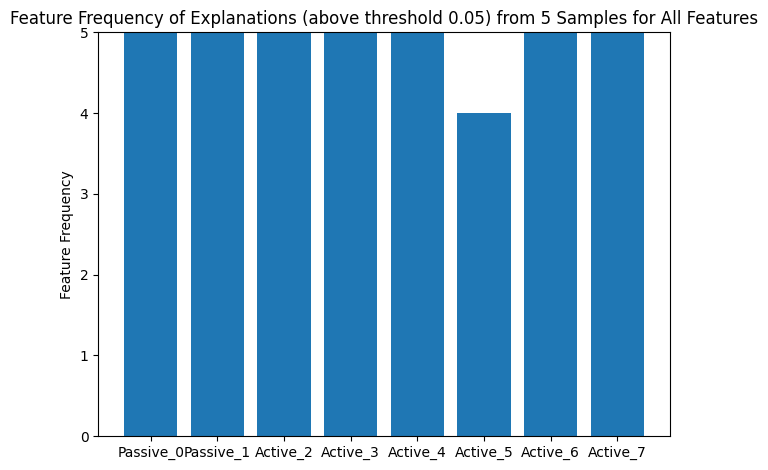

In [18]:
Reg_Stats.Frequency_Plot()


Average, SD, and Max Differences:
y - BB(x):           49.678116163994524  :  44.49088718646426  :  129.20480595006245
y - exp(x):          49.67811617281281  :  44.49088718050365  :  129.20480594897833
BB(x) - exp(x):      9.251921539998875e-09  :  8.193534739804258e-09  :  2.4835969725245377e-08
Average exp(x) Uncertainty:  1.0000000413701846e-05
R Score:   1.0
Fidelity:  1.0


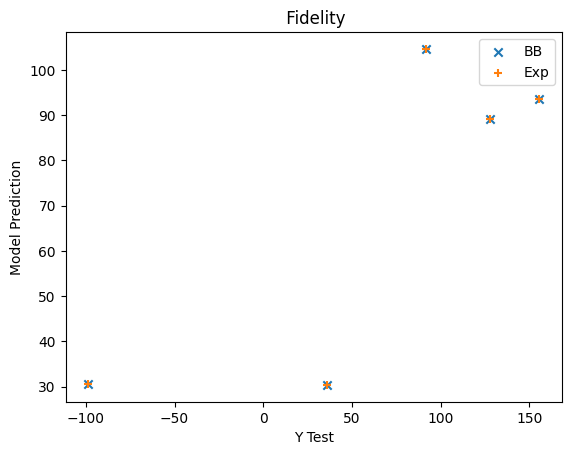

In [19]:
Reg_Stats.Fidelity()

In [20]:
Reg_Stats.Jaccard_Values()

Mean Jaccard Similarity:  1.0
Mean Jaccard Distance:    0.0


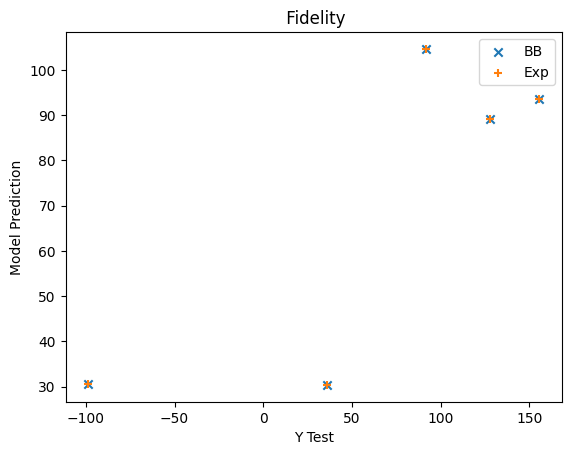

In [21]:
Reg_Stats.Reg_Fidelity_Graph()

top_features True
top_features (5, 8)


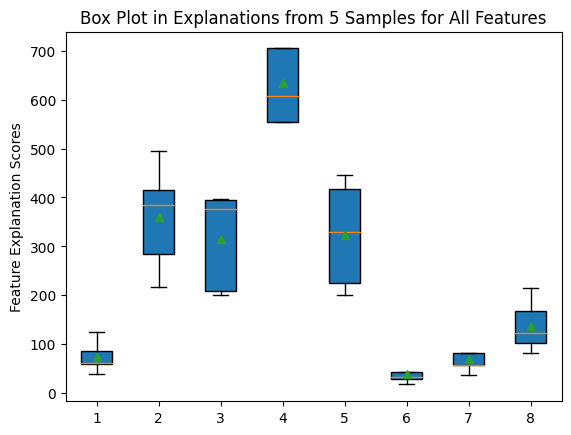

1 -      Passive_0
2 -      Passive_1
3 -      Active_2
4 -      Active_3
5 -      Active_4
6 -      Active_5
7 -      Active_6
8 -      Active_7


In [22]:
Reg_Stats.Box_Plot()


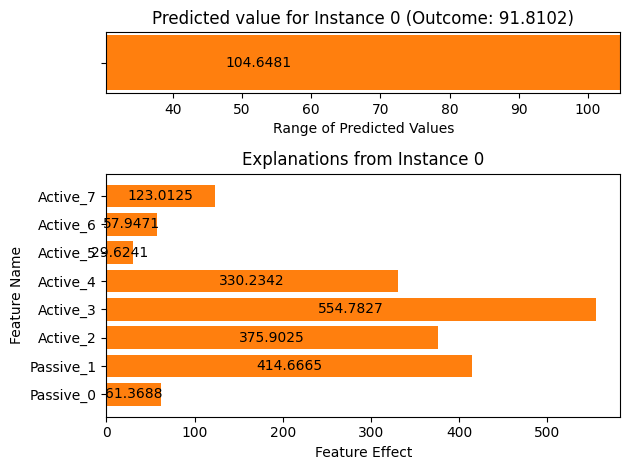

In [23]:
Reg_Stats.View_Explanation(instance = 0)

In [24]:
scores = URM_Exp.permutation_importance()
    
print(scores)

[ 168.45686323  615.6488621   466.06111684 1300.06775987  493.09564418
   94.36483267  161.15235315  282.48155017]


In [25]:
scores_k = URM_Exp.KL_imp()

print(scores_k)

[ 6.84714017  7.42448476  7.21900157 11.41004608  6.65257218  6.85415146
  6.84782566  6.83107891]


In [26]:
scores_v = URM_Exp.Var_imp()

print(scores_v)

[ 44.8277805  103.95323788  71.68826363 334.06240699  58.3287431
  43.85729659  44.729847    46.44247704]


In [27]:
scores_d1 = URM_Exp.del_1_rel()

print(scores_d1)

[1.01887499 0.90706566 1.01888953 1.01830218 0.99557892 1.01862323
 1.00441331 1.01825218]


In [28]:
scores_d2 = URM_Exp.del_2_rel()

print(scores_d2)

[4.33800691e-03 9.98656058e-01 5.38550739e-03 6.91390939e+00
 5.96185620e-02 1.57297492e-03 3.99157962e-03 1.25279178e-02]


In [29]:
lin_scores = URM_Exp.Lin_scores()

print(lin_scores)

[-2.36005886e+05 -1.49888289e+00  1.05262877e+00 -1.57381244e+01
  4.09692126e+00  4.78693992e+03  2.23811677e+05  9.98702399e+03]


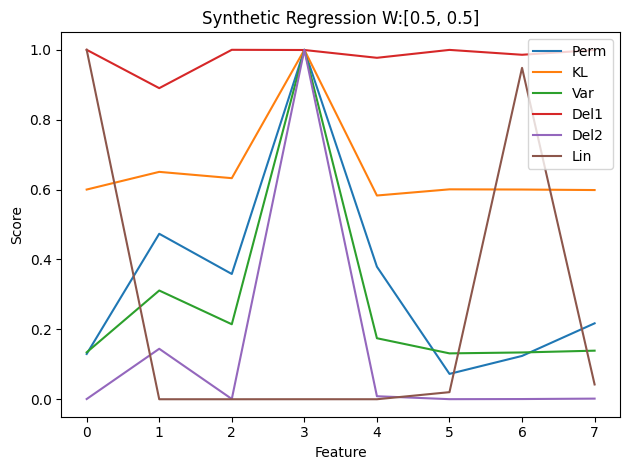

In [30]:
URM_Exp.plot_scores(Title)

In [31]:
print(URM_Exp.get_exp_L())


[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.47256349e-04  9.99999850e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.58936722e-03  6.69560144e-01  7.42756143e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.0

In [32]:
acq_data.Create_BB_plot()

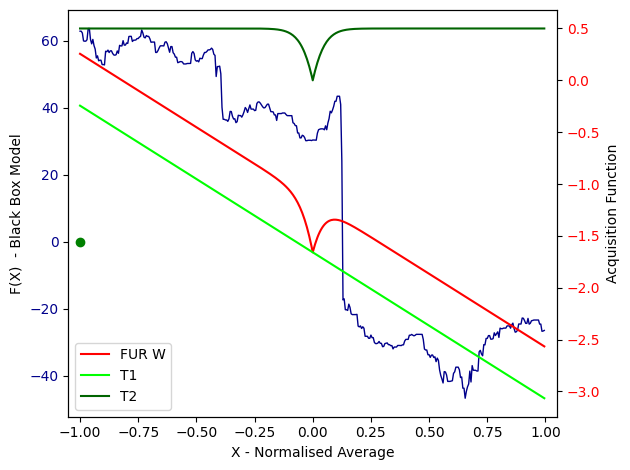

In [33]:
acq_data.plot_point(0)

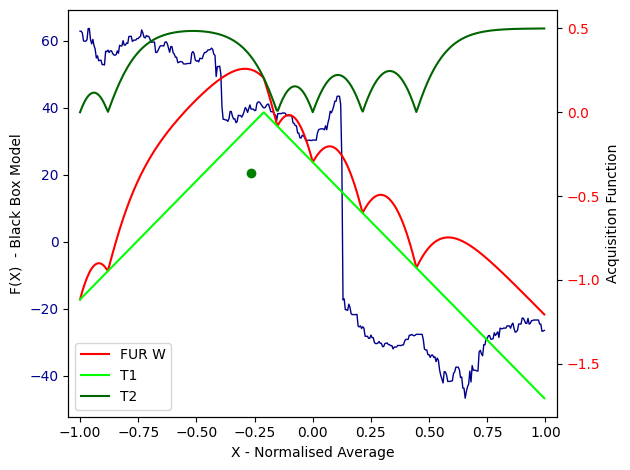

In [34]:
acq_data.plot_point(5)

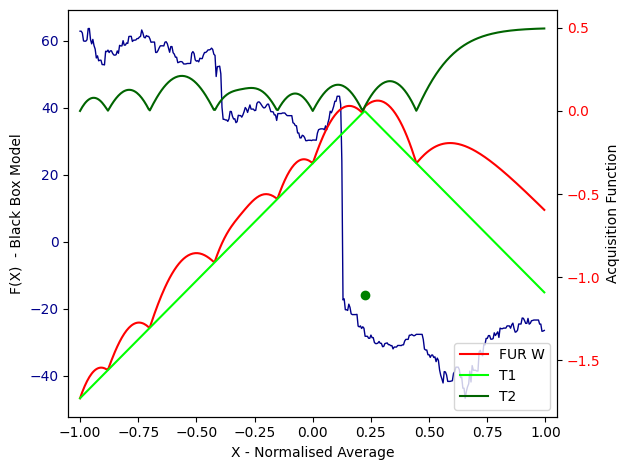

In [35]:
acq_data.plot_point(10)

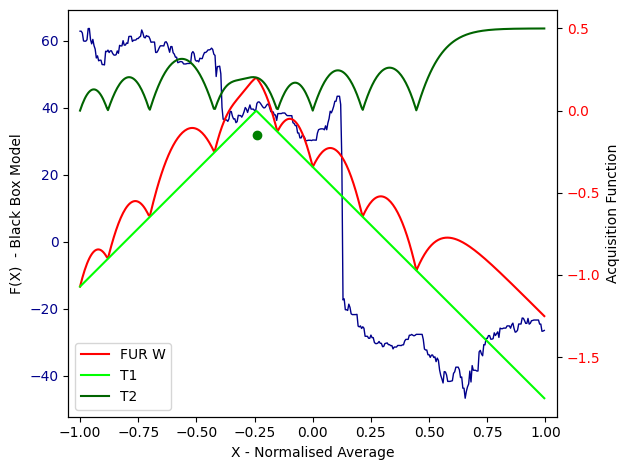

In [36]:
acq_data.plot_point(15)

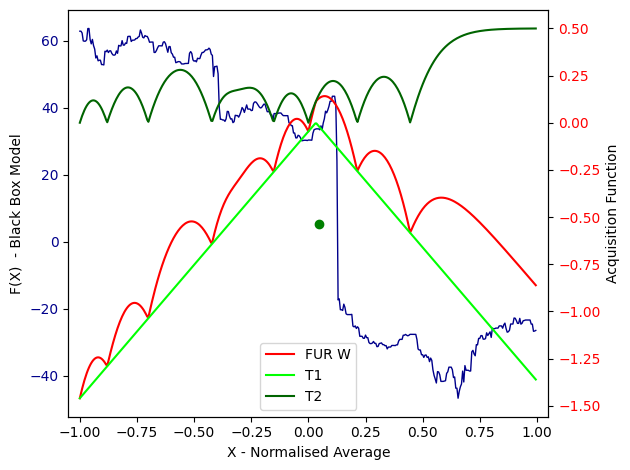

In [37]:
acq_data.plot_point(19)

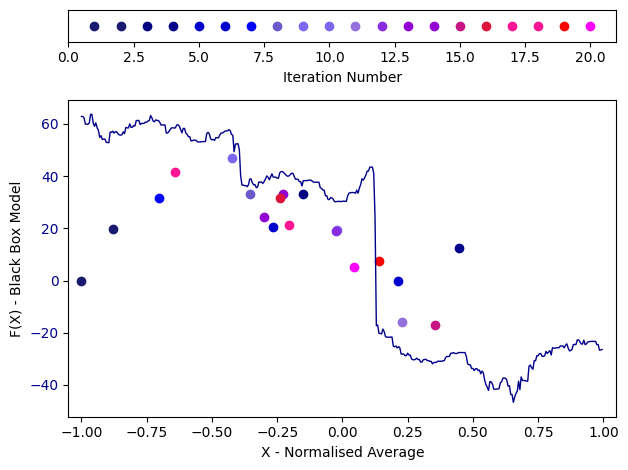

In [38]:
acq_data.plot_all()

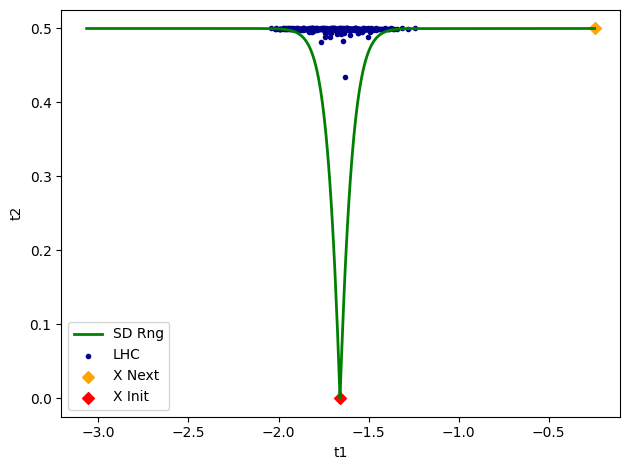

In [39]:
acq_data.plot_t1_t2(0)

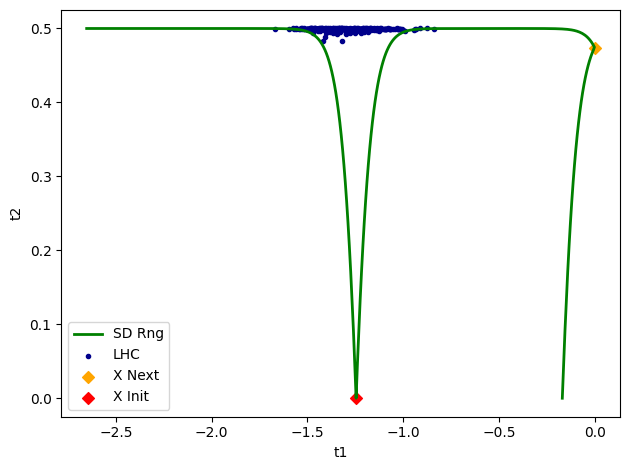

In [40]:
acq_data.plot_t1_t2(1)

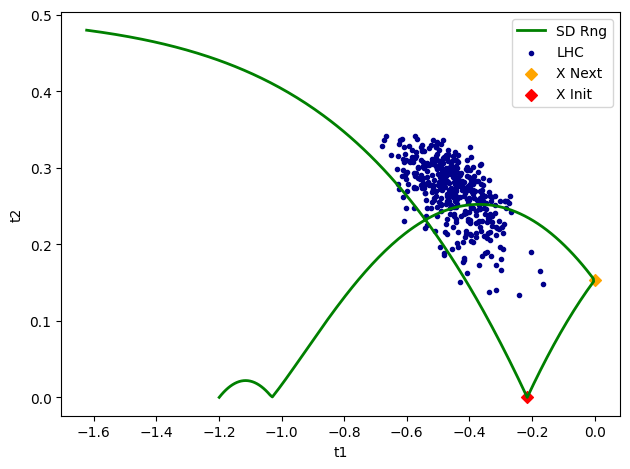

In [41]:
acq_data.plot_t1_t2(2)

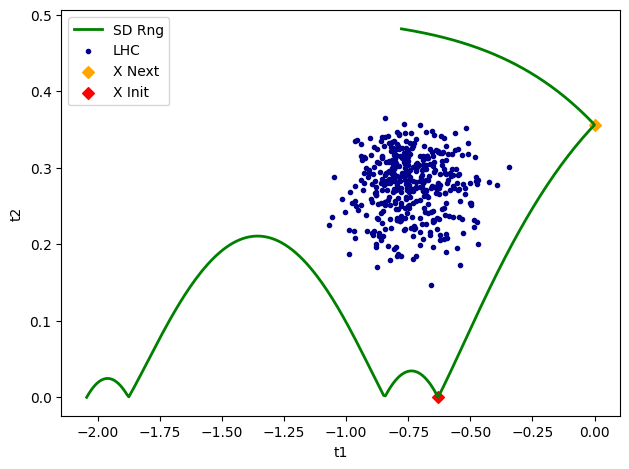

In [42]:
acq_data.plot_t1_t2(3)

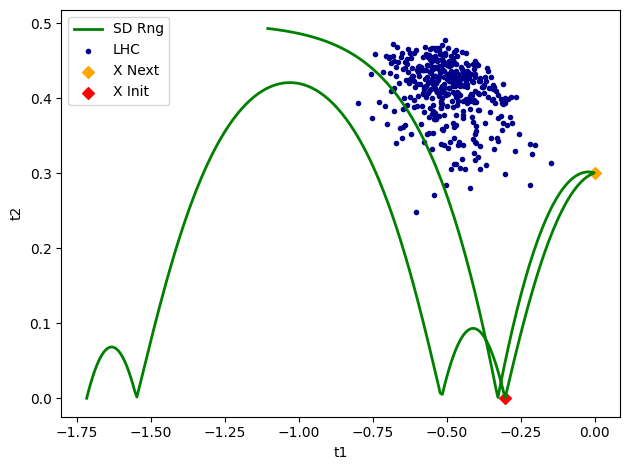

In [43]:
acq_data.plot_t1_t2(4)

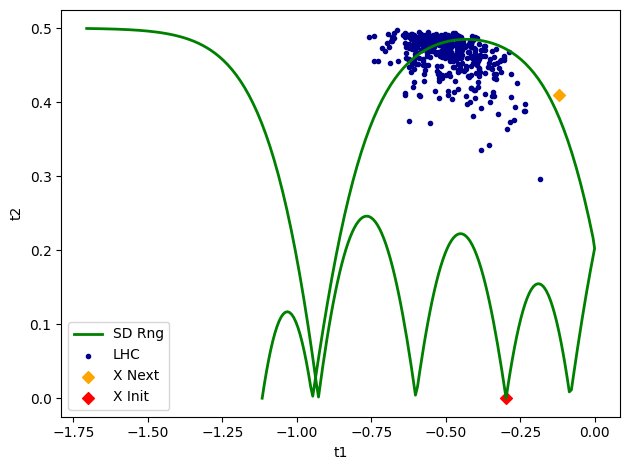

In [44]:
acq_data.plot_t1_t2(5)

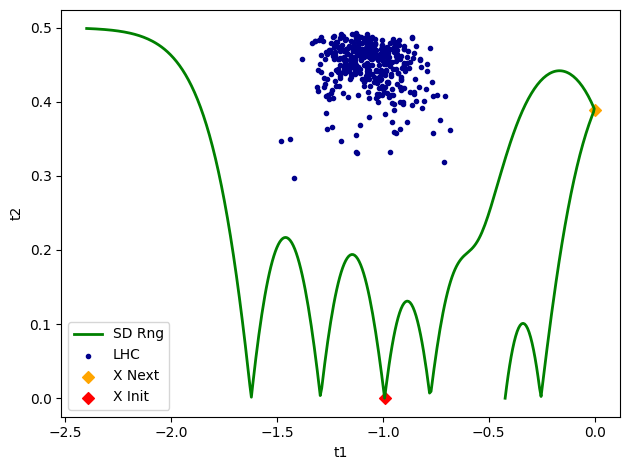

In [45]:
acq_data.plot_t1_t2(6)

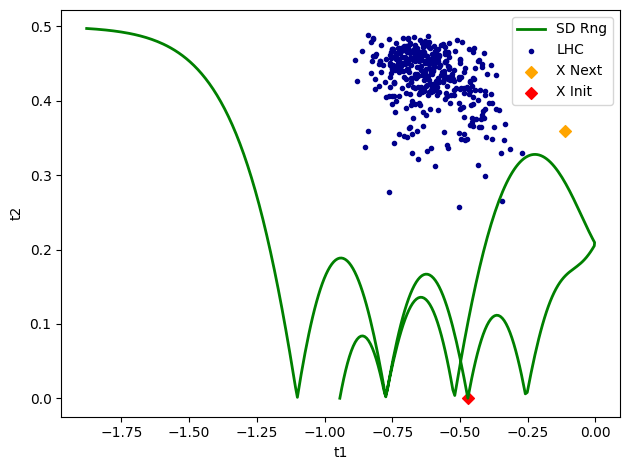

In [46]:
acq_data.plot_t1_t2(7)

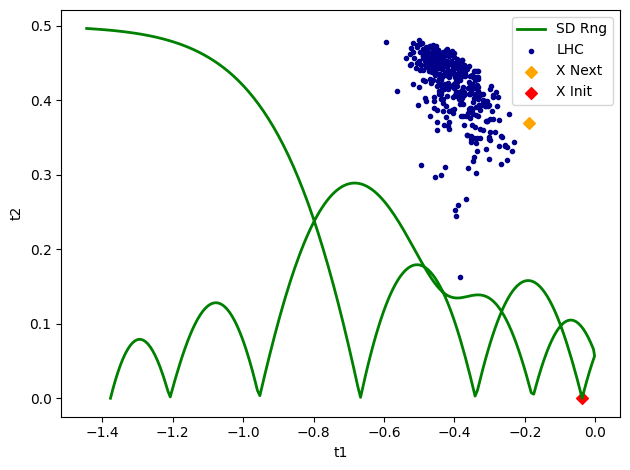

In [47]:
acq_data.plot_t1_t2(8)

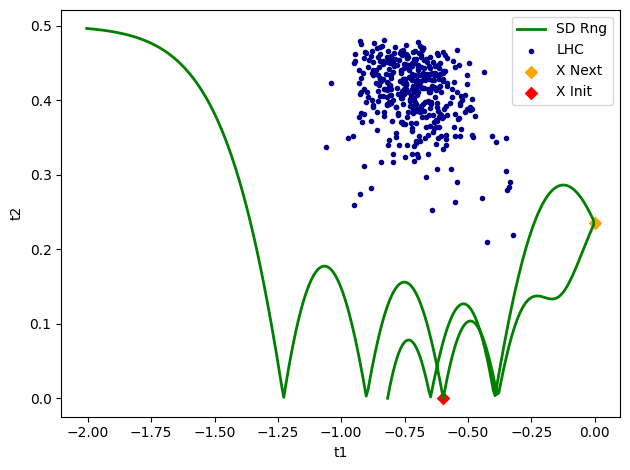

In [48]:
acq_data.plot_t1_t2(9)

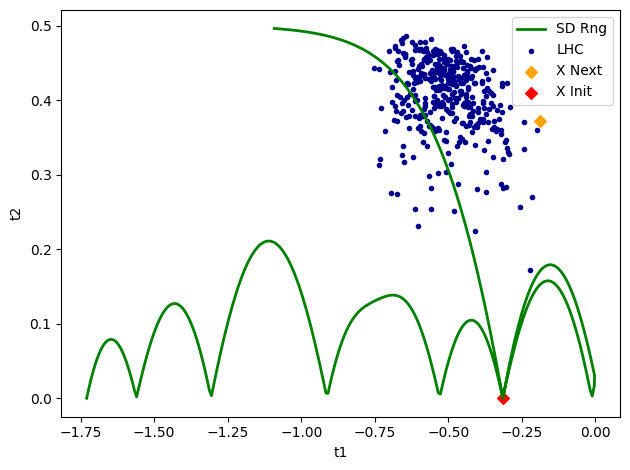

In [49]:
acq_data.plot_t1_t2(10)

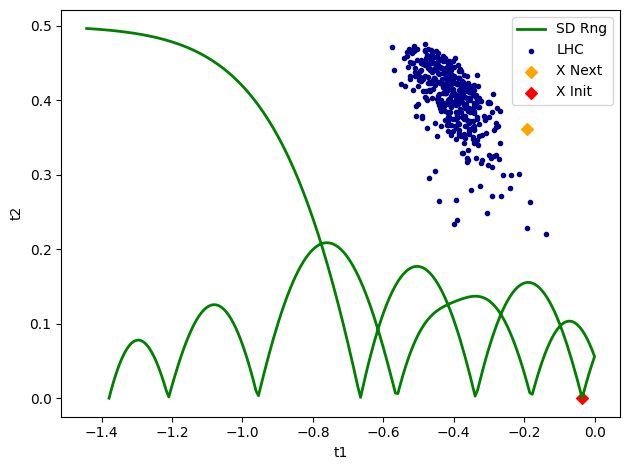

In [50]:
acq_data.plot_t1_t2(11)

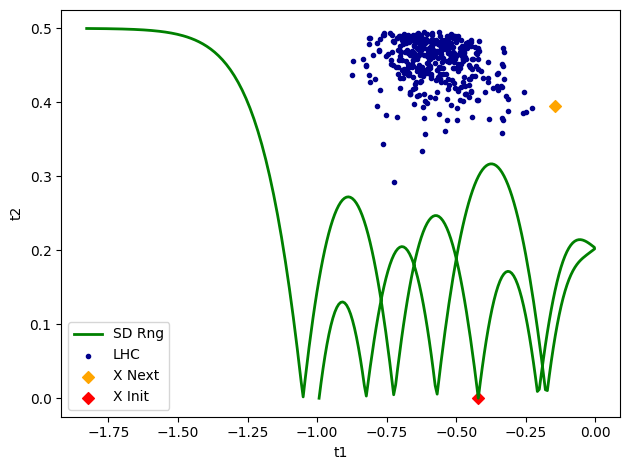

In [51]:
acq_data.plot_t1_t2(12)

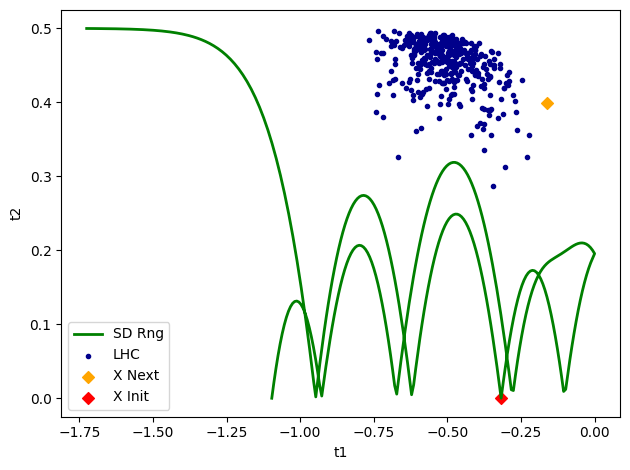

In [52]:
acq_data.plot_t1_t2(13)

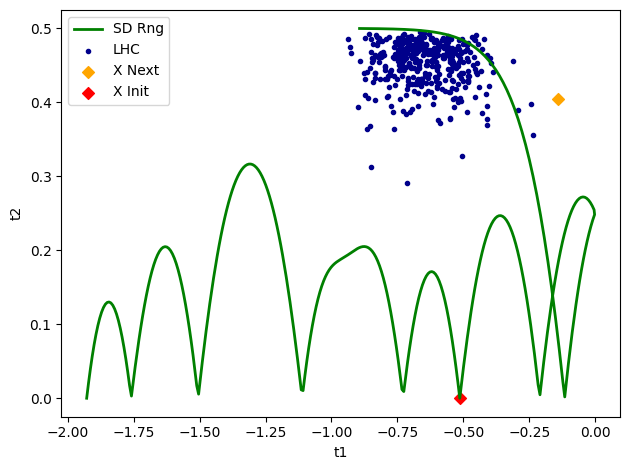

In [53]:
acq_data.plot_t1_t2(14)

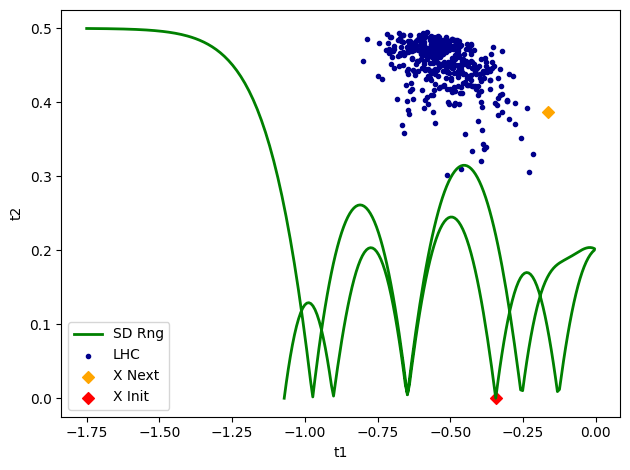

In [54]:
acq_data.plot_t1_t2(15)

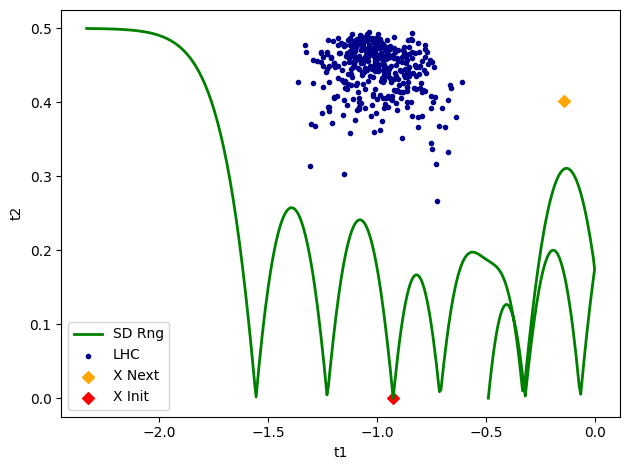

In [55]:
acq_data.plot_t1_t2(16)

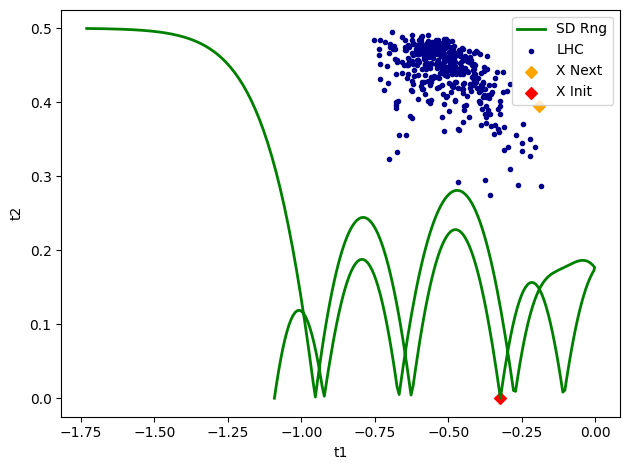

In [56]:
acq_data.plot_t1_t2(17)

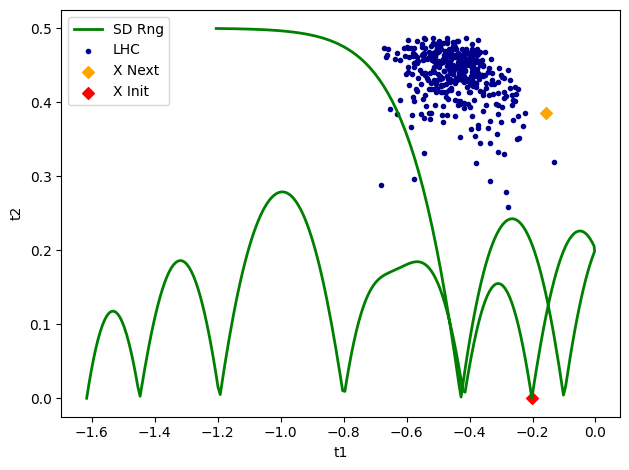

In [57]:
acq_data.plot_t1_t2(18)

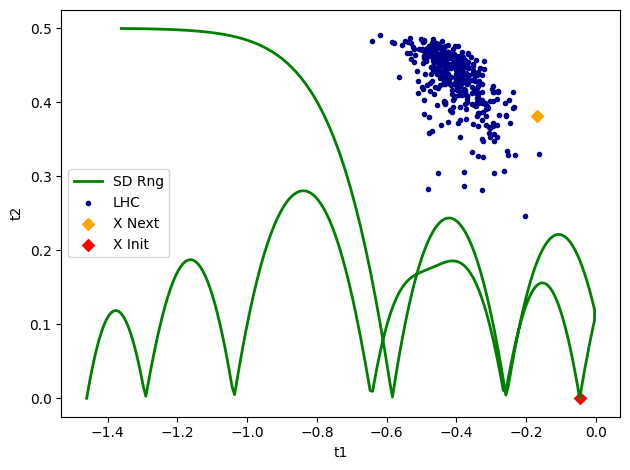

In [58]:
acq_data.plot_t1_t2(19)

Average, SD, and Max Differences:
y - BB(x):           49.678116163994524  :  44.49088718646426  :  129.20480595006245
y - exp(x):          49.67811617281281  :  44.49088718050365  :  129.20480594897833
BB(x) - exp(x):      9.251921539998875e-09  :  8.193534739804258e-09  :  2.4835969725245377e-08
Average exp(x) Uncertainty:  1.0000000413701846e-05
R Score:   1.0
Fidelity:  1.0


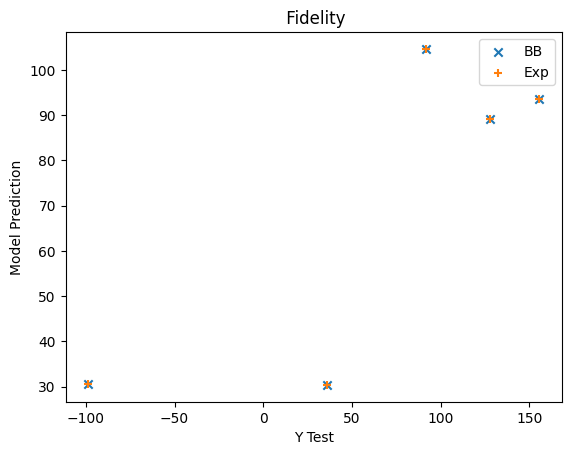

Fidelity:  0.9999999999460871


In [59]:
Reg_Stats.Fidelity()

print('Fidelity: ', Reg_Stats.fidelity)

In [60]:
Reg_Stats.Jaccard_Values(top_k=4)

print('Jaccard: ', Reg_Stats.jaccard_similarities)

Mean Jaccard Similarity:  1.0
Mean Jaccard Distance:    0.0
Jaccard:  1.0


In [61]:
Reg_Stats.add_Feature_Coeffs(Feature_Coeffs = Reg_Data.get_Feature_Coeffs())
        
print('Coeff Ratio: ', Reg_Stats.coeffs_ratio)

Mean Coeffs Ratio:  [ 0.          0.          4.29577231 -3.35153455 -3.11282448 69.15885491
 23.24825521 -3.84421726]
Feature Coeff Correlation:  -0.7183972131536573
Coeff Ratio:  [ 0.          0.          4.29577231 -3.35153455 -3.11282448 69.15885491
 23.24825521 -3.84421726]


In [62]:
delete_1_var = Reg_Stats.delete_one()


mean_variance [69.03586569 36.39648551 69.42856428 49.22353992 32.70898092 68.04782375
 50.11657348 67.23578043]
Mean scores: [ 73.88320667 359.68213184 315.2642691  635.12495762 323.89935382
  38.11478752  70.15191677 137.9340581 ]
sort_order [5 6 0 7 2 4 1 3]
norm sorted_scores [0.15604389 0.28720554 0.30248163 0.5647091  1.29070807 1.32606055
 1.47255708 2.60023412]
norm sorted_variance [1.23109555 0.90669014 1.24897083 1.21640437 1.25607539 0.59175854
 0.65847148 0.89053371]


<class 'AttributeError'>: 'Feature_Statistics_R' object has no attribute 'BB_del_1_var'

In [ ]:
Reg_Stats.Consistancy(std_bound = consist_bound, plot=True, title = Title)

In [ ]:
Reg_Stats.Compare_Models (model_b = Reg_Stats_2)

In [ ]:
Reg_Stats.Regression_Calibration(plot=True, title=Title)

In [ ]:
print(Reg_Stats.calibration_MAE)

In [ ]:
Reg_Stats.Regression_Calibration_2(plot=True, title=Title)

In [ ]:
Reg_Stats.delete_one()

In [ ]:
Reg_Stats.Results_Summary(Title)